<center><img src="http://milestonetechs.com/media/filer_public_thumbnails/filer_public/24/26/24260fc4-2637-4348-b2bd-3c333f2f806d/python_logo.jpg__800x250_q85_crop_subsampling-2.jpg" width="1000"></center>

# Programa de Especialización en Python

## Tema 2. Análisis de conglomerados: caso práctico

### Prof. Manuel Sigüeñas, M.Sc.(c)
[msguenas@socialdata-peru.com](msguenas@socialdata-peru.com)

<a id='beginning'></a>

**Caso: determinantes de las palabras claves para Marketing.**

1. [Diccionario de datos para el conjunto de datos de documentos aceptados](#part1)


2. [Librerías requeridas para este caso](#part2)


3. [Exploración de la data](#part3)


4. [Transformación de la data para el modelo](#part4)


5. [K-means](#part5)

    a. [Glusterización y Análisis de Componentes Principales](#part6)
    
    b. [Wordcloud](#part7)


6. [Gaussian Mixture](#part8)

In [1]:
from IPython.display import Image
%matplotlib inline

In [2]:
%load_ext watermark
%watermark -a "Social Data Consulting" -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn

Social Data Consulting 
last updated: 2019-10-04 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
pandas 0.24.2
matplotlib 3.0.3
scipy 1.2.1
sklearn 0.21.3




## Caso: determinantes de las palabras claves para Marketing
##### Danish Haroon (2017) - Python Machine Learning Case Studies

##### ¿Agrupar sobre palabras claves?

Ross, director de Marketing de una conferencia de IA, cuenta con un conjunto de datos para el diseño de una campaña de Marketing.

Sobre el data set construído brindado por Ted pensó que una estrategia podría ser utilizar el grupo por palabras clave o grupos. Luego podría publicar anuncios segmentados en redes sociales y utilizar la optimización de motores de búsqueda (SEO). Sin embargo, hay muchos valores diferentes dentro de las palabras claves y las características del grupo, y por lo tanto, darían lugar a muchos grupos de palabras clave SEO. Su estrategia se ha desglosado por varias palabras clave SEO diferentes.


##### ¿Solución?

Análisis clúster

- ¿Cuántos grupos serían óptimos a partir de los datos proporcionados? 
- Dado que los datos son pequeños, ¿puede algún algoritmo de ML adaptarse mejor a ellos? 
- ¿Cómo debe presentar visualmente los datos y, en última instancia, los resultados? 

##### Preguntas:

Ross creía que comprender las características de los datos proporcionados por Ted sería beneficioso más adelante en el camino. Sintió que la comprensión lo ayudaría a resolver el problema.

<a id='part1'></a>
### Diccionario de datos para el conjunto de datos de documentos aceptados

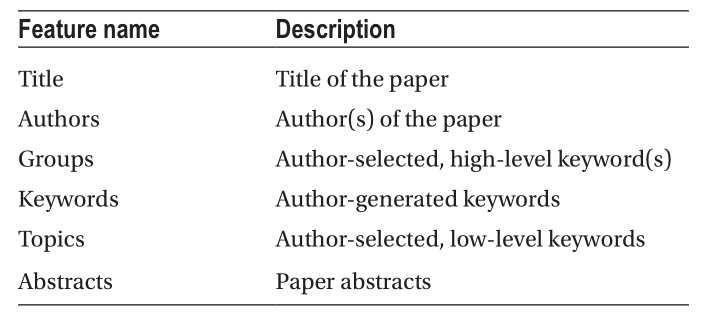

In [3]:
Image(filename='D:/Python/2. Nivel II/1/imagenes/data_set.png', width=400) 

- Para este caso el autor solo tomo 4 varibles. Title, Groups, Keywords y Topics

[Ir a Inicio](#beginning)

_____

<a id='part2'></a>
### Librerías requeridas para este caso


- Instalación del paquete necesario para el caso

In [5]:
#pip install wordcloud

- Activación de los paquetes.

In [4]:
%matplotlib inline
import pandas as pd
import operator
import itertools
import numpy as np
import pandas as pd
#from ggplot import *
import seaborn as sns
import matplotlib as mpl
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import euclidean_distances, silhouette_score
rcParams['figure.figsize'] = 15, 5

[Ir a Inicio](#beginning)

_____

<a id='part3'></a>
### Exploración de la data

 - Se ubica el archivo **csv** y luego es almacenando en el objeto **data_train**. Y así, se separa en base a 4 columnas (Título, Grupo, Palabras Clave, Tema).

In [6]:
data_train = pd.read_csv('D:/Python/2. Nivel II/1/datos/[UCI] AAAI-14 Accepted Papers - Papers.csv')
data_train = data_train[['title', 'groups', 'keywords', 'topics']]

- "#" de datos almacenados en la data

In [7]:
print(len(data_train))

398


- Vista de las 4 primeras filas de **data_train**

In [118]:
len(data_train)
data_train.head()

,index,title,keywords,topics,groups,flags
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0


[Ir a Inicio](#beginning)

_____

<a id='part4'></a>
### Transformación de la data para el modelo


¿Cómo aplicar el gluster a datos en formato texto?

La solución que maneja Ross, es hacerlo en base a la variable **groups**; es por eso, que el primer paso sera observar la cantidad de grupos al que pertenecen cada uno.



- Un Paper puede estar asociado a mas de un grupo, el separador de este es **\n**. Es por eso que se separan los grupos en base al símbolo, antes mencionado; y asi, si un trabajo de investigación cae dentro de tres grupos, estará representado por tres observaciones diferentes (es decir, filas) en el conjunto de datos.

In [119]:
s = data_train['groups'].str.split('\n').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'groups'
del data_train['groups']
data_train = data_train.join(s).reset_index()

- Se crea una nueva variable que indicara si cada Paper esta asignado a un grupo o no.
        -Además, se imprime la lista de los datos modificados.

In [120]:
data_train['flags'] = pd.Series(np.ones(len(data_train)), index=data_train.index)
data_train.head()

,level_0,index,title,keywords,topics,flags,groups
0,0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,1.0,Novel Machine Learning Algorithms (NMLA)
1,1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,1.0,AI and the Web (AIW)
2,2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,1.0,Novel Machine Learning Algorithms (NMLA)
3,3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,1.0,Game Theory and Economic Paradigms (GTEP)
4,4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,1.0,NLP and Text Mining (NLPTM)


- Una vez obtenido los datos, se crea una matriz. En el cual las columnas seran toda la relacion de los grupos; las filas, los Papers; el valor, la pertenencia a dicho grupo o no.

In [121]:
def matrix_from_df(data_train):

    matrix = data_train.pivot_table(index = ['title'], columns=['groups'], values='flags')
    matrix = matrix.fillna(0).reset_index()
    x_cols = matrix.columns[1:]
    return matrix, x_cols

- Vista de la matrix creada

In [122]:
matrix, x_cols = matrix_from_df(data_train)
matrix.head()

groups,title,AI and the Web (AIW),Applications (APP),Cognitive Modeling (CM),Cognitive Systems (CS),Computational Sustainability and AI (CSAI),Game Playing and Interactive Entertainment (GPIE),Game Theory and Economic Paradigms (GTEP),Heuristic Search and Optimization (HSO),Human-Computation and Crowd Sourcing (HCC),...,Multiagent Systems (MAS),NLP and Knowledge Representation (NLPKR),NLP and Machine Learning (NLPML),NLP and Text Mining (NLPTM),Novel Machine Learning Algorithms (NMLA),Planning and Scheduling (PS),Reasoning under Uncertainty (RU),Robotics (ROB),Search and Constraint Satisfaction (SCS),Vision (VIS)
0,"""Source Free"" Transfer Learning for Text Class...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,A Characterization of the Single-Peaked Single...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"A Computational Method for (MSS,CoMSS) Partiti...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,A Control Dichotomy for Pure Scoring Rules,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Convex Formulation for Semi-supervised Multi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[Ir a Inicio](#beginning)

_____

<a id='part5'></a>
### K-means

Para este caso, Ross menciona que el método que usara para agrupar es el k-means.
Consiste en:

1. Los k-centroides se eligen aleatoriamente. 
2. Cada una de las observaciones está ligada con el centroide más cercano. 
3. Los nuevos centroides para cada uno de los grupos se vuelven a calcular tomando la media de las observaciones que se encuentran dentro de cada grupo. 
4. El paso 2 se repite nuevamente.

Ahora, el método para crear grupos sera el k-means.

- Aún asi, ¿Cuántos grupo serían los óptimos a partir de los datos proporcionados?

El autor menciona, que existen 3 algoritmos que nos pueden ayudar a conocer el número óptimo de grupos.

1. Aplicación del Elbow Method.
        -Determina cuánta varianza marginal contribuye un grupo agregado recientemente.

Text(0.5, 1.0, 'Elbow for KMeans clustering')

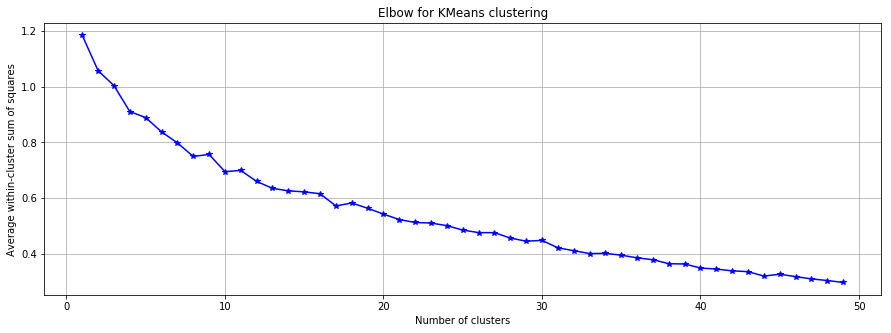

In [123]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

Curva del Elbow Method codo en función del número de grupos.

    -El codo esta en el k=9.

2. Variance Explainend
        - Es la relación de la varianza del grupo a la varianza total.

 - Aplicando el Ebow Method y Variance Explainend a la matriz de datos.

Text(0.5, 1.0, 'Elbow for KMeans clustering')

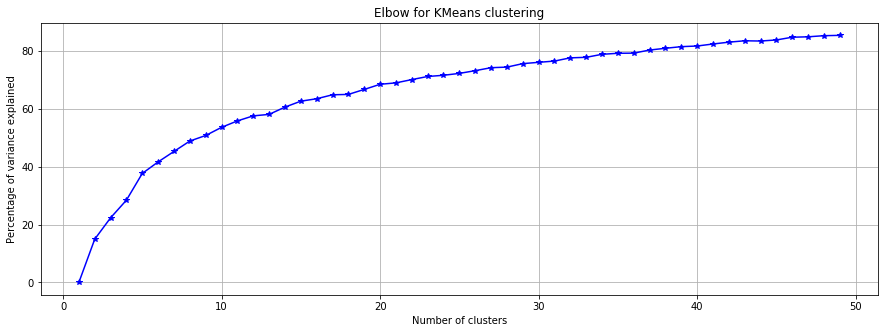

In [142]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]

wcss = [sum(d**2) for d in dist]
tss = sum(pdist(X)**2)/X.shape[0]
bss = tss-wcss

kIdx = 10-1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')








plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')

Explicación de la curva de varianza en función del número de grupos. Posible número de grupos ideales 9.

3. Silhoutte Score.

- Trazado de gráficos de los coeficientes de Silhouette Score por cada número de cluster generado por K-means. (de 2 a 30)
            - El puntaje es de 1 a -1 

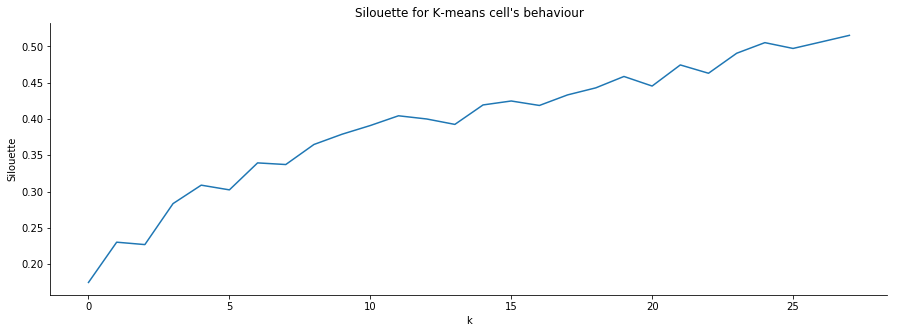

In [125]:
s = []

for n_clusters in range(2,30):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    s.append(silhouette_score(X, labels, metric='euclidean'))

plt.plot(s)
plt.ylabel("Silouette")
plt.xlabel("k")
plt.title("Silouette for K-means cell's behaviour")
sns.despine()

Los coeficientes de silueta se representan en función del número de grupos.

    *El puntaje aumenta conforme lo hacen el número de grupos.
    *Debido a la condicionante del tiempo, el autor, solo tomo 9 grupos.

[Ir a Inicio](#beginning)

_____

<a id='part6'></a>
#### a. Glusterización y Análisis de Componentes Principales

Una vez establecido el número ideal de grupos a analizar se procede a crear los 9 grupos.

- Aplicación de la agrupación de k-means con un tamaño de agrupación de 9 en el Listado. 

In [126]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

cluster = KMeans(n_clusters = 9, random_state = 2)
matrix['cluster'] = cluster.fit_predict(X)
matrix.cluster.value_counts()

0    81
1    78
5    44
3    38
6    36
2    32
8    30
7    30
4    27
Name: cluster, dtype: int64

Muestra de los 9 grupos formados en orden descendente.

- Uso de PCA para transformar características relacionadas con el grupo en dos componentes. 
        - Para el autor la gran cantidad de dimensiones que poseen los datos, lo hace poco      intuitivo para poder observarse en una grafica. 
   

In [127]:
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['title', 'cluster', 'x', 'y']]
customer_clusters.head()

groups,title,cluster,x,y
0,"""Source Free"" Transfer Learning for Text Class...",1,0.615810,-0.060295
1,A Characterization of the Single-Peaked Single...,8,-0.756838,0.971322
2,"A Computational Method for (MSS,CoMSS) Partiti...",4,-0.287956,-0.216148
3,A Control Dichotomy for Pure Scoring Rules,2,-0.521295,0.570206
4,A Convex Formulation for Semi-supervised Multi...,3,0.198578,-0.129668


-  Trazar las agrupaciones en un espacio bidimensional.

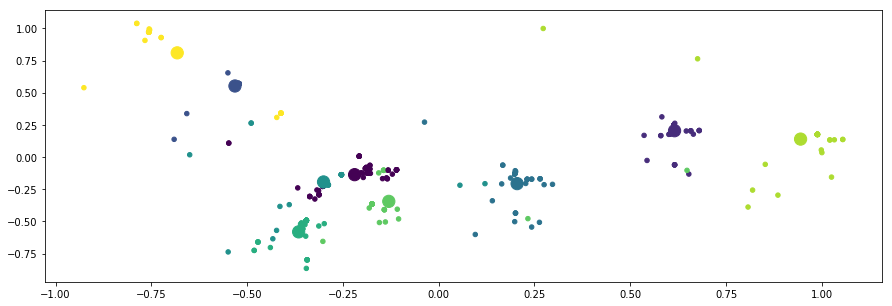

In [128]:
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))

plt.scatter(customer_clusters['x'], customer_clusters['y'], s = 20, c=customer_clusters['cluster'])
plt.scatter(cluster_centers['x'], cluster_centers['y'], s = 150, c=cluster_centers['cluster'])

Clusters en espacio bidimensional

- Matriz de fusión en el marco de datos original.

In [129]:
customer_clusters.columns.name = None
df = data_train.merge(customer_clusters, on='title')
df.head()

,level_0,index,title,keywords,topics,flags,groups,cluster,x,y
0,0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,1.0,Novel Machine Learning Algorithms (NMLA),1,0.613870,0.245408
1,1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,1.0,AI and the Web (AIW),1,0.615810,-0.060295
2,2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,1.0,Novel Machine Learning Algorithms (NMLA),1,0.615810,-0.060295
3,3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,1.0,Game Theory and Economic Paradigms (GTEP),2,-0.521295,0.570206
4,4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,1.0,NLP and Text Mining (NLPTM),0,-0.183192,-0.090091


Impresión de observaciones del marco de datos combinado.

[Ir a Inicio](#beginning)

_____

<a id='part7'></a>
#### b. Wordcloud

Representación visual de la palabras de un texto, donde el tamaño es mayor de acuerdo al numero de veces que aparece en el texto. Para este caso, una vez formados los 9 grupos, se usara la variable **keywords**; para generar el **Wordcloud**.

-  Creación de una función para generar el **wordcloud**

In [130]:
def wordcloud_object(word_string):

    FONT_ROOT = './fonts/'
    wordcloud = WordCloud(font_path=FONT_ROOT + 'arial.ttf',stopwords=STOPWORDS, background_color='black', width=1200, height=1000).generate(' '.join(word_string))
    return wordcloud

- Crear una función para trazar Wordcloud para cada clúster.

In [131]:
def plot_wordcloud(df, clusters, pivot):

    fig = plt.figure(figsize=(15,29.5))
    for cluster in range(clusters):
        List_ = []

        for x in df[df['cluster']==cluster][pivot]:
            try:
                List_.extend(x.split('\n'))
            except:
                pass

        if List_:
            ax = fig.add_subplot(5,2,cluster+1)
            wordcloud = wordcloud_object(List_)
            plt.title('Cluster: %d'%(cluster+1))
            ax.imshow(wordcloud)
            ax.axis('off')

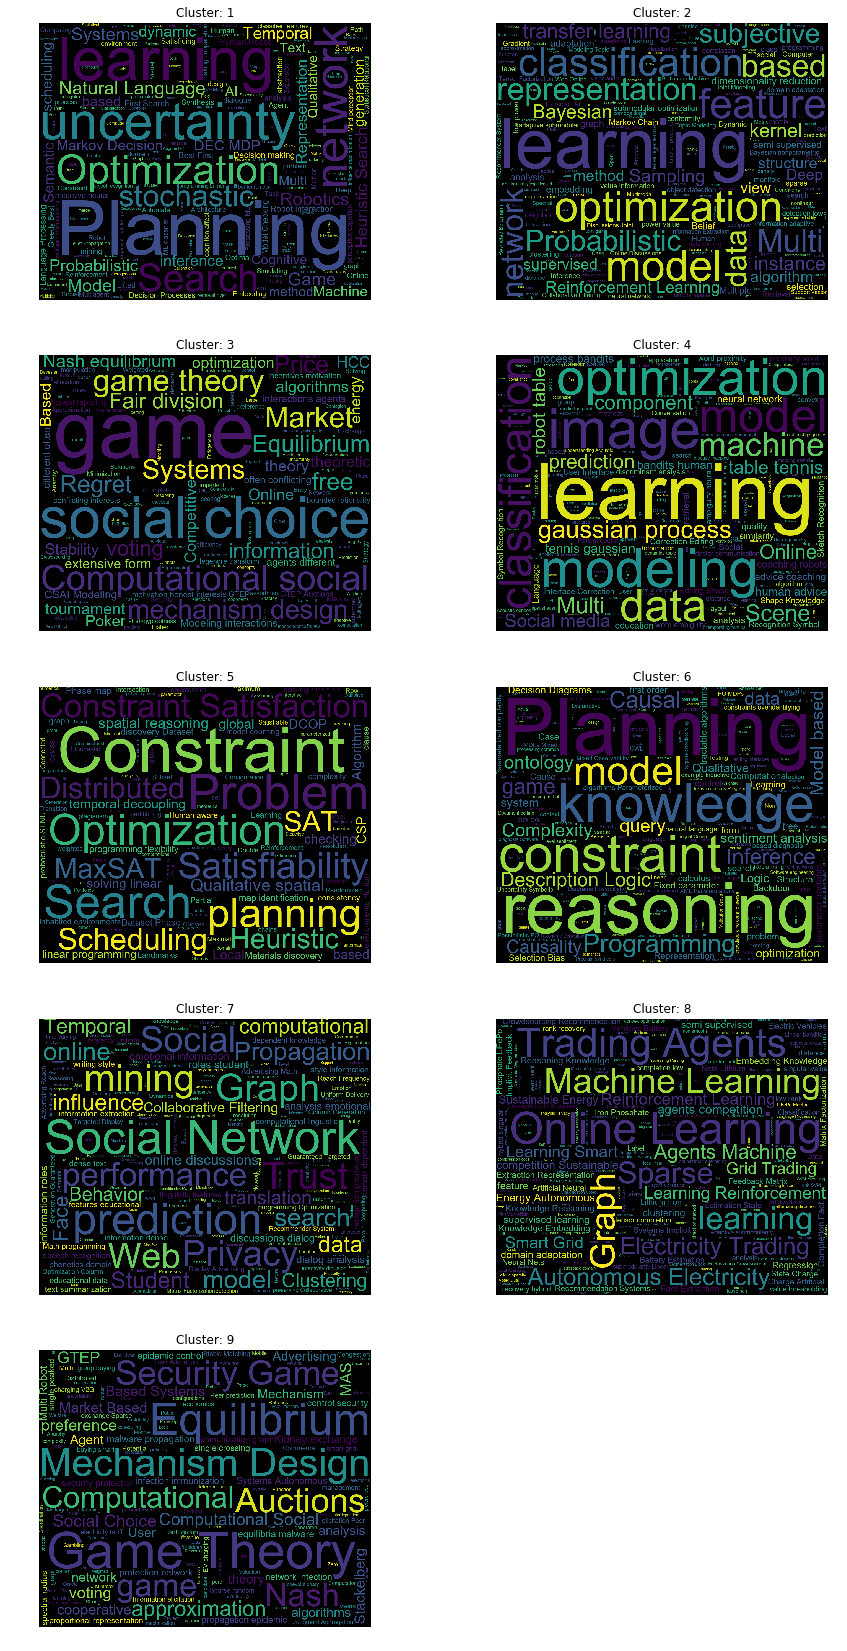

In [132]:
plot_wordcloud(df, cluster.n_clusters, 'keywords')

Wordcloud para cada clúster generado a partir de palabras clave.

- Grupo 1: Documentos que hablan sobre búsqueda y robótica
- Grupo 2: Documentos que hablan en profundidad sobre el aprendizaje y la optimización de los modelos - Grupo 3: Temas de aplicación de análisis de datos en juegos y análisis de redes sociales • Grupo 4: Temas de reconocimiento de imágenes, robótica y análisis de redes sociales 
- Grupo 5: Temas de programación lineal y búsqueda 
- Grupo 6: Documentos sobre modelos basados en razonamiento 
- Grupo 7: documentos sobre la aplicación de las ciencias de datos en gráficos sociales y otros medios en línea 
- Grupo 8: temas que varían en gráficos de conocimiento 
- Grupo 9: documentos que se concentran en la teoría de juegos y la seguridad de los datos

- Definir método para buscar palabras clave completas para clústeres dados.
        - El autor identificó palabras superpuestas; por ello, se cerciora que al menos estas palabras no toquen temas similares en los papers.

In [133]:
def perform_cluster_group_audit(clusters, term):

    for cluster in clusters:

        df_cluster = df[df['cluster'] == cluster]
        print ('Cluster number: %d'%(cluster + 1))
        keywords = list(df_cluster['keywords'])
        keywords = [keyword.split('\n') for keyword in keywords]
        keywords = [item for sublist in keywords for item in sublist]
        keywords = [keyword.lower() for keyword in keywords if term in keyword.lower()]
        keywords_freq = {x:keywords.count(x) for x in keywords}
        print (sorted(keywords_freq.items(), key=operator.itemgetter(1), reverse=True))
        print ('\n')

- Uso de la función para buscar la palabras clave **"search"** en los clúteres 0 y 4.

In [134]:
perform_cluster_group_audit([0,4], 'search')

Cluster number: 1
[('heuristic search', 7), ('greedy best first search', 4), ('monte carlo tree search', 2), ('similarity search', 1), ('approximate nearest neighbor search', 1), ('incremental search', 1), ('real-time search', 1), ('agent-centered search', 1), ('hierarchical search', 1), ('parallel search', 1), ('bounded suboptimal search', 1), ('best-first search', 1), ('suboptimal heuristic search', 1)]


Cluster number: 5
[('heuristic search', 3), ('search', 3), ('local search', 2), ('stochastic local search', 2), ('and/or search', 2)]




- Uso de la función para buscar la palabra clave **"social"** en los clústeres 2, 3 y 6.

In [135]:
perform_cluster_group_audit([2,3,6], 'social')

Cluster number: 3
[('computational social choice', 11), ('social choice theory', 2), ('social decision schemes', 2), ('randomized social choice', 1)]


Cluster number: 4
[('social media', 5), ('social spammer', 2), ('social image classification', 2)]


Cluster number: 7
[('social networks', 6), ('social infectivity', 3), ('social network', 3), ('location based social network', 2), ('social network analysis', 2), ('social influence', 2), ('social dynamics', 1), ('social explanation', 1)]




*Se observa, que los grupos observados no presentan similitud en los temas. El grupo 4, toca los temas de imagenes sociales; a diferencia del grupo 3, que enfatiza las teorías de elección social.

[Ir a Inicio](#beginning)

_____

<a id='part8'></a>
### Gaussian Mixture

Ross se dio cuenta que el aplicando el k-means, los grupos creados no tenian sentido intuitivo y decidio aplicar este modelo; ya que, según él, los modelos de mezcla gaussiana se pueden considerar como una mejora de k-means donde se toma en consideración la covarianza de los datos y los centros de los modelos gaussianos.


- Función de definición para trazar los grupos.

In [136]:
def plot_results(X, Y_, means, covariances, index, title):

    color_iter = itertools.cycle(['b', 'g', 'red', 'm', 'y', 'navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(0.0, 0.1)
    plt.ylim(-0.2, 1.2)
    
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

- Determinación del tipo de covarianza y componentes óptimos para el modelo y su trazado.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


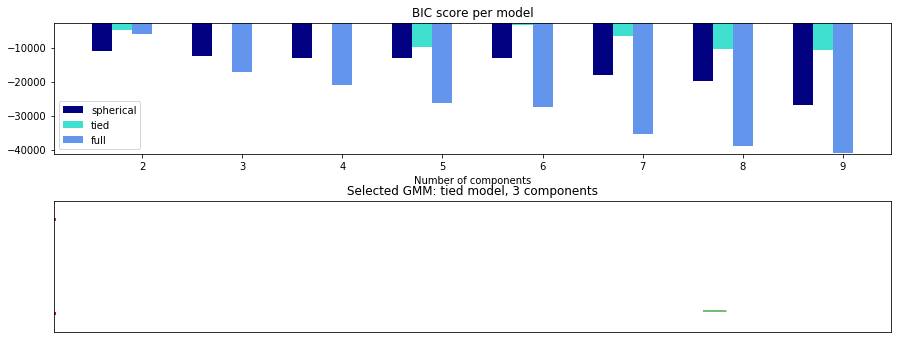

In [137]:
matrix, x_cols = matrix_from_df(data_train)
X  = matrix[x_cols].as_matrix()
model_stats = []
n_components_range = range(2, 10)
cv_types = ['spherical', 'tied', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:

        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type, random_state=0)
        gmm.fit(X)
        model_stats.append({'name':'%s_%d'%(cv_type, n_components), 'model':gmm, 'bic':gmm.bic(X)})

bic = np.array([m_type['bic'] for m_type in model_stats])
best_gmm = model_stats[bic.argmax()]
clf = best_gmm['model']
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue'])

bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

labels = clf.predict(X)
plot_results(X, labels, gmm.means_, gmm.covariances_, 1,
             'Gaussian Mixture-%s'%gmm.converged_)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: %s model, %s components'%(best_gmm['name'].split('_')[0], best_gmm['name'].split('_')[1]))
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()


Puntaje BIC por modelo

*El modelo Gaussiano arroja como el número ideal de grupos a 3.

- Mostrar frecuencia de objetos en cada grupo.

In [138]:
matrix['cluster'] = labels
matrix.cluster.value_counts()

0    232
1    108
2     56
Name: cluster, dtype: int64

-	Matriz de fusión en el marco de datos inicial.

In [139]:
customer_clusters.columns.name = None
df = data_train.merge(customer_clusters, on='title')

- Generando Wordclouds de características denominadas "palabras clave"

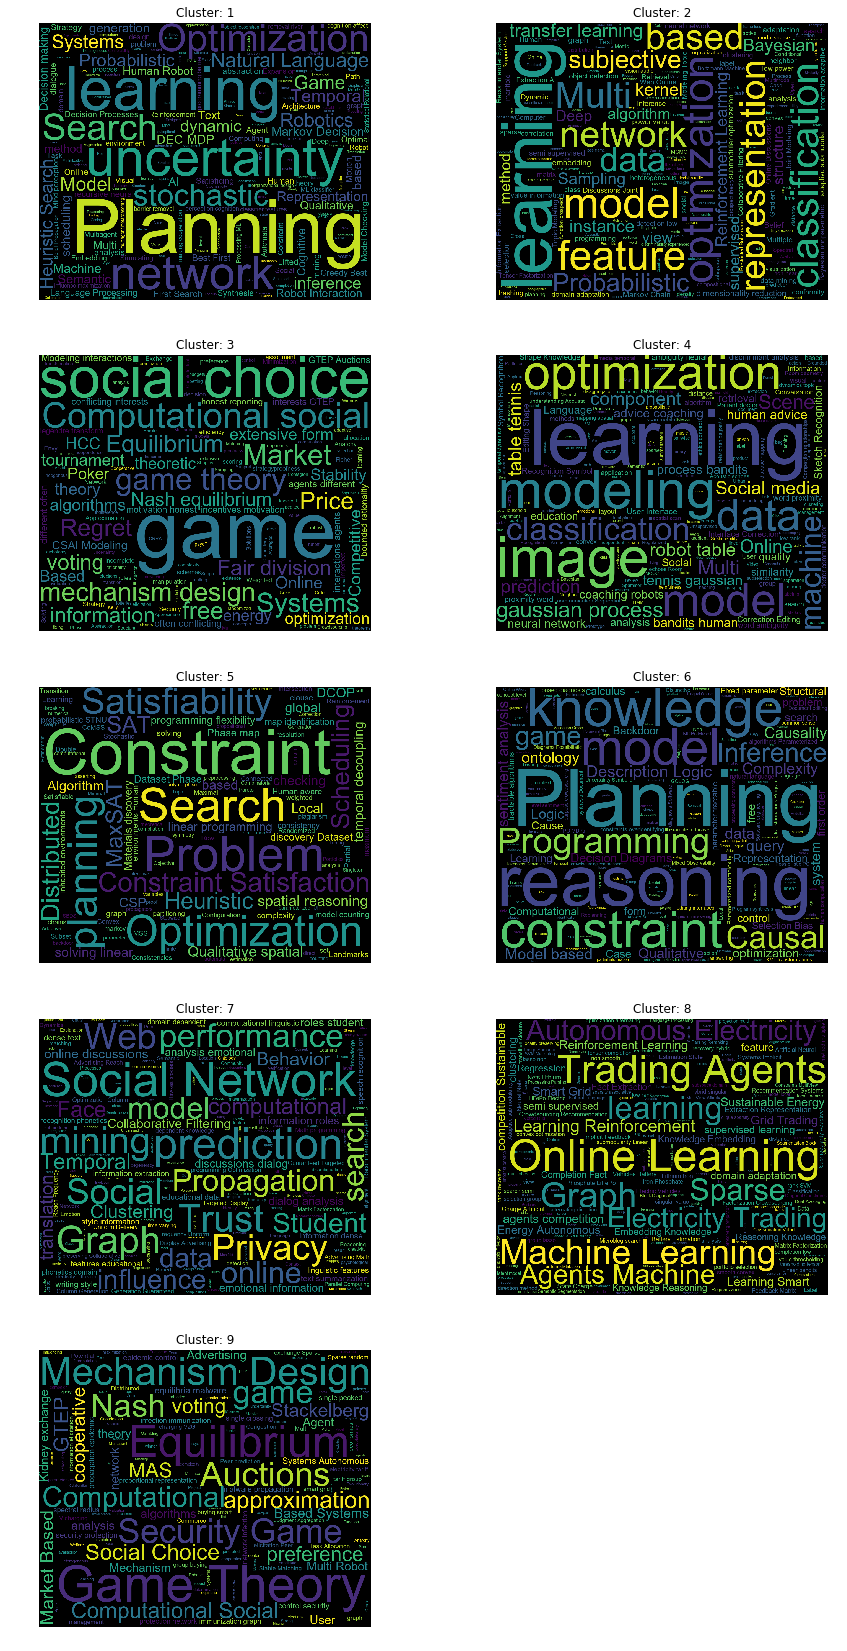

In [140]:
plot_wordcloud(df, gmm.n_components, 'keywords')

- Entrenando el modelo y trazando los grupos

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


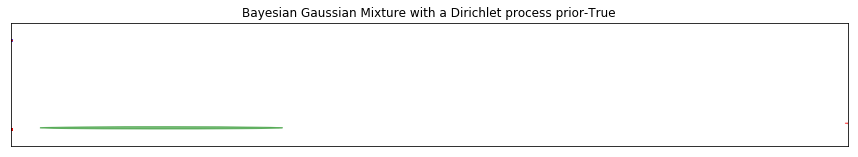

In [141]:
matrix, x_cols = matrix_from_df(data_train)
X  = matrix[x_cols].as_matrix()

dpgmm = mixture.BayesianGaussianMixture(n_components=3,
                                        covariance_type='full', random_state=1).fit(X)

labels = dpgmm.predict(X)
plot_results(X, labels, dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior-%s'%dpgmm.converged_)

plt.show()

Racimos formados por medio del modelo de mezcla gaussiana bayesiana

-  Mostrar frecuencia de objetos en cada grupo.

In [94]:
matrix['cluster'] = labels
matrix.cluster.value_counts()

0    229
1    117
2     50
Name: cluster, dtype: int64

- Matriz de fusión en el marco de datos inicial

In [95]:
customer_clusters.columns.name = None
df = data_train.merge(customer_clusters, on='title')

- Generando Wordclouds de características denominadas "palabras clave".

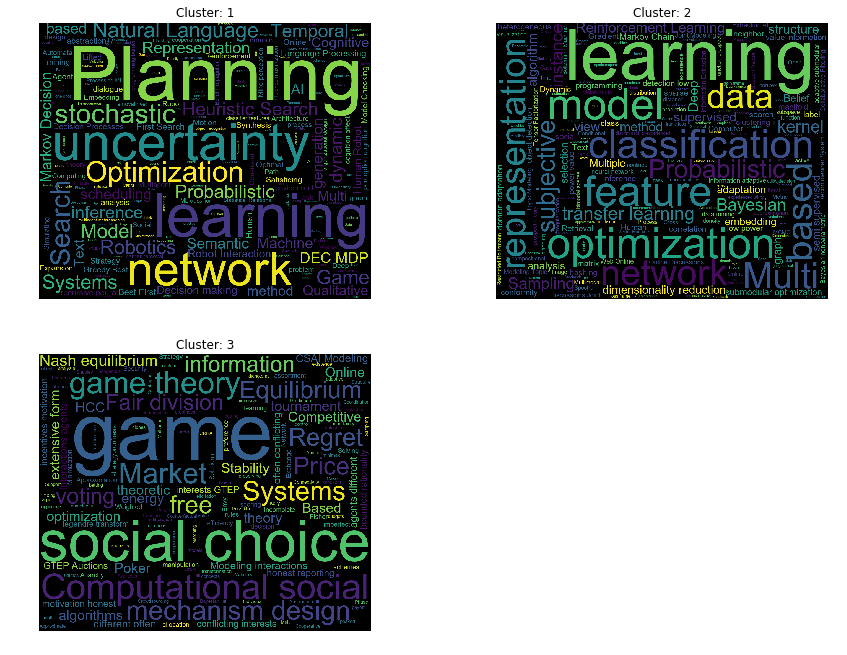

In [96]:
plot_wordcloud(df, dpgmm.n_components, 'keywords')

Ross definió los tres grupos con la ayuda de los grupos en las siguientes palabras: 

- Grupo 1: documentos que analizan en profundidad la teoría de juegos y análisis de redes sociales 
- Grupo 2: documentos que analizan en profundidad la optimización de modelos y el aprendizaje de modelos 
- Grupo 3: temas sobre programación lineal, gráficos de conocimiento y modelos basados en razonamiento



[Ir a Inicio](#beginning)

_____